<a href="https://colab.research.google.com/github/ibrahim1023/ml-fundamentals/blob/main/Linear_Regression_GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression for Housing Prices — Math, GD, Scaling & LR Sweep

End-to-end demo: dataset → MSE cost → gradient → batch GD → loss curves → contour intuition → closed-form check → fits comparison.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=4)


## Synthetic Housing Data (size → price)

In [ ]:
rng = np.random.default_rng(42)
m = 140
size = rng.uniform(500, 3500, size=m)  # sq ft
true_theta0, true_theta1 = 50.0, 0.15  # k$, k$/sqft
noise = rng.normal(0, 15, size=m)     # k$
price = true_theta0 + true_theta1 * size + noise
X = np.c_[np.ones_like(size), size]
y = price.reshape(-1, 1)
m, X.shape, y.shape


(140, (140, 2), (140, 1))

## Scatter Plot

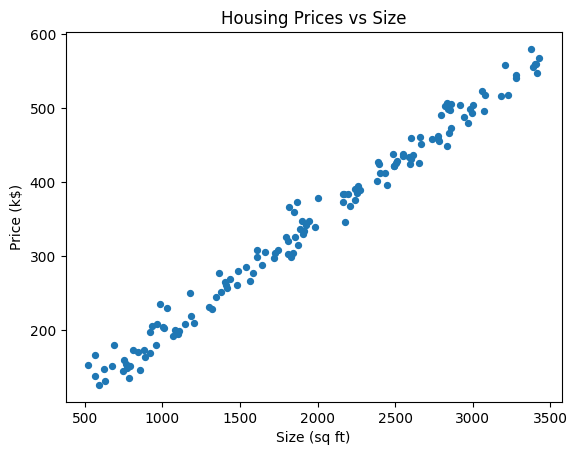

In [ ]:
plt.figure()
plt.scatter(size, price, s=18)
plt.xlabel('Size (sq ft)')
plt.ylabel('Price (k$)')
plt.title('Housing Prices vs Size')
plt.show()


## Cost & Gradient (Math)
MSE with convenient factor:
$$J(\theta)=\tfrac{1}{2m}\sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})^2,\quad h_\theta = X\theta.$$
Gradient:
$$\nabla_\theta J(\theta)=\frac{1}{m}X^\top(X\theta-y),\quad \theta\leftarrow\theta-\alpha\nabla_\theta J(\theta).$$


In [ ]:
def cost(theta, X, y):
    m = len(y)
    r = X @ theta - y
    return float((r.T @ r) / (2*m))

def grad(theta, X, y):
    m = len(y)
    return (X.T @ (X @ theta - y)) / m

def batch_gd(X, y, alpha=1e-7, steps=800, theta0=None):
    theta = np.zeros((X.shape[1], 1)) if theta0 is None else theta0.copy()
    J_hist, theta_hist = [], []
    for t in range(steps):
        g = grad(theta, X, y)
        theta = theta - alpha * g
        J_hist.append(cost(theta, X, y))
        theta_hist.append(theta.copy())
    return theta, J_hist, theta_hist


## Baseline: Unscaled Feature (small α)

In [ ]:
theta_unscaled, J_unscaled, path_unscaled = batch_gd(X, y, alpha=1e-7, steps=1400)
print('θ (unscaled) ≈', theta_unscaled.ravel())


θ (unscaled) ≈ [0.001  0.1719]


/tmp/ipython-input-1430203708.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((r.T @ r) / (2*m))


### Loss Curve — Unscaled

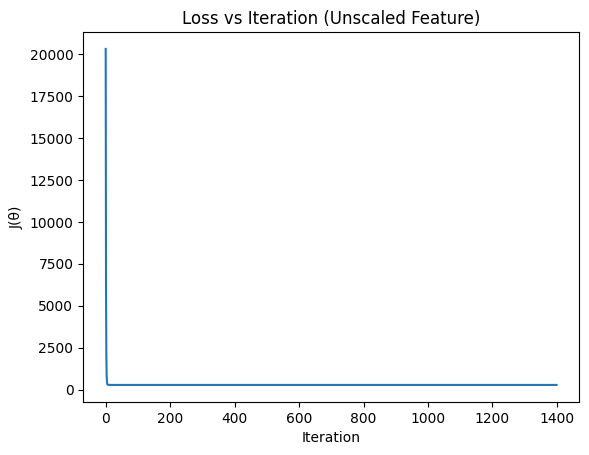

In [ ]:
plt.figure()
plt.plot(J_unscaled)
plt.xlabel('Iteration')
plt.ylabel('J(θ)')
plt.title('Loss vs Iteration (Unscaled Feature)')
plt.show()


## Feature Scaling (Standardization)
$$x_{scaled} = \frac{x-\mu}{\sigma}$$ allows larger α and faster convergence.

In [ ]:
mu, sigma = size.mean(), size.std()
size_scaled = (size - mu) / sigma
X_scaled = np.c_[np.ones_like(size_scaled), size_scaled]
theta_scaled, J_scaled, path_scaled = batch_gd(X_scaled, y, alpha=1e-2, steps=500)
print('θ (scaled space) ≈', theta_scaled.ravel())

# Map back to original units
b, w = theta_scaled.ravel()
theta1_orig = w / sigma
theta0_orig = b - (w * mu) / sigma
theta_from_scaled = np.array([theta0_orig, theta1_orig])
print('θ mapped back (original units) ≈', theta_from_scaled)


θ (scaled space) ≈ [342.0123 125.0076]
θ mapped back (original units) ≈ [45.6651  0.151 ]


/tmp/ipython-input-1430203708.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((r.T @ r) / (2*m))


### Loss Curve — Scaled

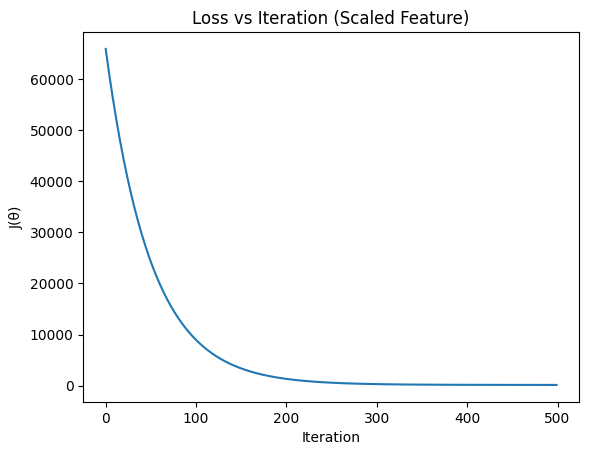

In [ ]:
plt.figure()
plt.plot(J_scaled)
plt.xlabel('Iteration')
plt.ylabel('J(θ)')
plt.title('Loss vs Iteration (Scaled Feature)')
plt.show()


## Closed-Form (Normal Equation)

In [ ]:
theta_closed = np.linalg.pinv(X.T @ X) @ (X.T @ y)
print('θ (closed-form) ≈', theta_closed.ravel())


θ (closed-form) ≈ [45.9671  0.152 ]


## Fit Comparison (Unscaled GD vs Scaled→Original vs Closed-Form)

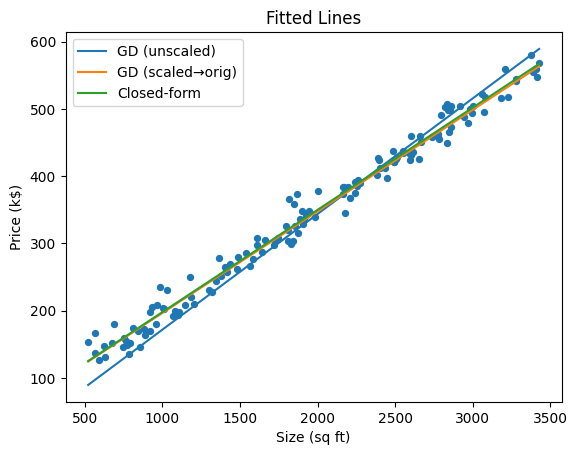

In [ ]:
grid_x = np.linspace(size.min(), size.max(), 200)
grid_X = np.c_[np.ones_like(grid_x), grid_x]
y_unscaled = grid_X @ theta_unscaled
y_scaled_back = grid_X @ theta_from_scaled.reshape(-1,1)
y_closed = grid_X @ theta_closed
plt.figure()
plt.scatter(size, price, s=18)
plt.plot(grid_x, y_unscaled.ravel(), label='GD (unscaled)')
plt.plot(grid_x, y_scaled_back.ravel(), label='GD (scaled→orig)')
plt.plot(grid_x, y_closed.ravel(), label='Closed-form')
plt.xlabel('Size (sq ft)')
plt.ylabel('Price (k$)')
plt.title('Fitted Lines')
plt.legend()
plt.show()


## Learning-Rate Sweep (on Scaled Feature)

/tmp/ipython-input-1430203708.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((r.T @ r) / (2*m))


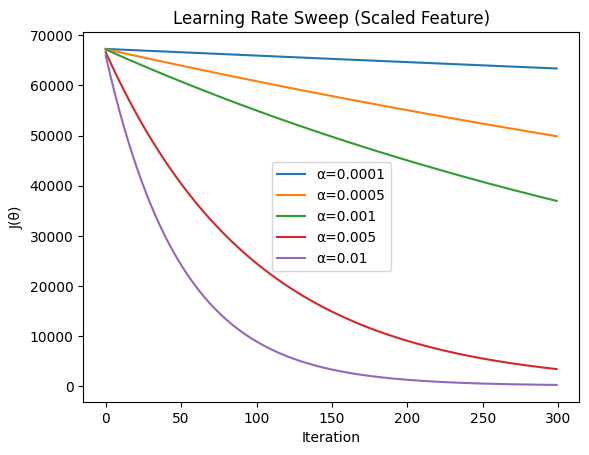

In [ ]:
alphas = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
histories = {}
for a in alphas:
    _, Jh, _ = batch_gd(X_scaled, y, alpha=a, steps=300)
    histories[a] = Jh
plt.figure()
for a in alphas:
    plt.plot(histories[a], label=f'α={a}')
plt.xlabel('Iteration')
plt.ylabel('J(θ)')
plt.title('Learning Rate Sweep (Scaled Feature)')
plt.legend()
plt.show()


## Contour Intuition (Optional)

/tmp/ipython-input-1430203708.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float((r.T @ r) / (2*m))


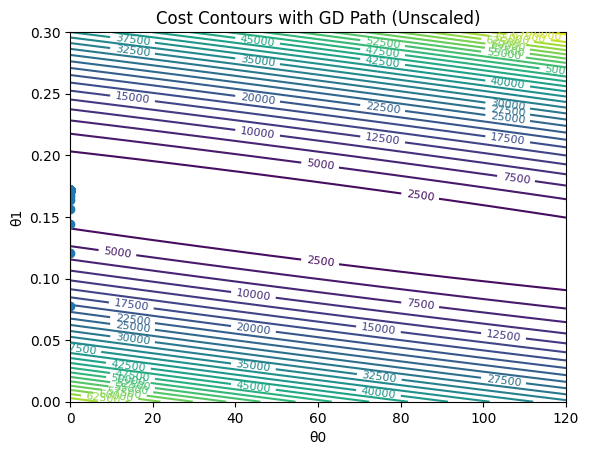

In [ ]:
theta0_vals = np.linspace(0, 120, 120)
theta1_vals = np.linspace(0.0, 0.3, 120)
J_grid = np.zeros((len(theta0_vals), len(theta1_vals)))
for i, t0 in enumerate(theta0_vals):
    for j, t1 in enumerate(theta1_vals):
        th = np.array([[t0],[t1]])
        J_grid[i, j] = cost(th, X, y)
T0, T1 = np.meshgrid(theta0_vals, theta1_vals, indexing='ij')
plt.figure()
CS = plt.contour(T0, T1, J_grid, levels=30)
plt.clabel(CS, inline=True, fontsize=8)
path = np.array(path_unscaled).reshape(-1, 2)
plt.plot(path[:,0], path[:,1], marker='o')
plt.xlabel('θ0')
plt.ylabel('θ1')
plt.title('Cost Contours with GD Path (Unscaled)')
plt.show()


## Notes for your article
- **Why scaling helps:** Makes feature magnitudes comparable → better-conditioned optimization → permits larger α.
- **Pick α:** Start small; increase until you approach fastest *non-diverging* curve (see sweep).
- **Convexity:** Linear regression + MSE is convex → single global minimum; GD will find it with appropriate α.
- **Closed-form vs GD:** Normal equation is exact but not streaming-friendly; GD scales to big data and enables regularization easily.
